**GUIA 5**

**Ejercicio 1: Modelo de presa predador Lotka-Volterra**

---



El modelo de Lotka-Volterra describe la dinámica de interacción de dos poblaciones, y esta dado por

$$ u_t =   au - buv + D_1 u_{xx}, $$
$$ v_t = - cv + duv + D_2 v_{xx}. $$

En estas ecuaciones $u(x,t)$ es la densidad de presas, $v(x,t)$ la de predadores, $a$ la tasa de nacimiento de presas, $c$ la tasa de muerte de predadores, $b$ y $d$ son los acoplamientos entre especies, y $D_1$ y $D_2$ sus difusividades.


**a**) Resolvé numéricamente el sistema considerando condiciones de contorno periódicas en el dominio unidimensional $x \in [0,2\pi)$, utilizando un método a elección. Elegí todos los parámetros y definí las condiciones iniciales para $u$ y para $v$. Explicá detalladamente la elección del método, de los parámetros y de las condiciones iniciales. Describí la dinámica del sistema en término de las soluciones obtenidas.

**b**) Utilizando tu modelo numérico mostrá el efecto que tienen los coeficientes de difusión en el modelo. *Ayuda: probá distintos valores de* $D_1$ y $D_2$

**Ejercicio 2: Modelo para la propagación del fuego, ecuación de Kuramoto-Sivashinsky**

---




La ecuación de Kuramoto-Sivashinsky viene dada por

$$ u_t = -u_{xx} -u_{xxxx} - (u_x)^2/2 $$

Derivando respecto a x y tomando $v = u_x$ se tiene

$$ v_t = -v_{xx} -v_{xxxx} - vv_x, $$

de donde puede verse que el término $v_{xx}$ representa la reacción, que $v_{xxxx}$ es el término de disipación y $vv_x$ es el término advectivo.


**a**) Qué simetrías tiene esta ecuación? Basado en esto, y dado un dominio de longitud L y cdc periódicas elegí una base de Fourier y escribí una proyección de Galerkin de esta ecuación, hasta llegar a la expresión explícita para la evolución temporal del sistema.

**b**) Linealizando la expresión hallada en el punto previo, estudiá los puntos fijos y la estabilidad. Para esto, escribi explícitamente los primeros cuatro modos y estudiá la primera bifrucación del sistema. Describi detalladamente la dinámica del sistema en terminos de este analisis.

**c**) Integrá la ecuación numéricamente con condiciones de contorno periódicas, utilizando un método numérico a elección. *Ayuda: Para trabajar con una variable $x \in [0,2\pi)$ y poder cambiar fácilmente la longitud total del recinto a *$2\pi L$, *redefini* $x'=x/L$ y $t'=t/L^2$. *La ecuación que se obtiene entonces es*

$$ u_{t'} = -u_{x'x'} -u_{x'x'x'x'}/L^2 - (u_{x'})^2/2 $$

Qué pasa si se extiende el dominio espacial a $n\pi$ (probá con distintos L)? Explicá detalladamente la dinámica que ves en relación al item previo (Ayuda: usa gráficos 2D de la solución obtenida). Es posible caracterizar las soluciones con unos pocos modos?

Para las $u(x,t)$ obtenidas numéricamente, puede resultar de mucha utilidad trabajar con la función de estructura de orden 2 de la velocidad, dada por

$$ S_2(l,t) = < [u(x+l,t)-u(x,t)]^2 > = <\delta u_l^2>  $$

la cual tiene un vínculo directo con el espectro de Energía  en el espacio de Fourier $E(k)$ ($S_2$ es la "energía en el espacio real"). De esta forma, ya sea con $E(k)$ o $S_2$, es posible argumentar acerca de la dinámica del sistema en términos de la cantidad de modos que estan excitados en la proyección de Galerkin, y de cual es su amplitud. Pero mas aún, en sistemas autosimilares, es posible hallar la dimension fractal del sistema. Si además el sistema es monofractal, toda la estadistica del sistema queda unívocamente determinada por $S_2$.^

**d**) Calculá la función de estructura $S_2(l)$ y el espectro de energía $E(k)$.

**e**)A partir de estos, hallá un rango de autosimilaridad para el cual puedan escribirse leyes de scala de la forma $E(k)\sim k^{\alpha}$ y $S_2(l)\sim l^{\beta}$. De acuerdo entonces a las soluciones numéricas, cuánto valen $\alpha$ y $\beta$? Qúe relación guardan entre si? Es lo esperado?

**f**) Opcional: Hallá la dimensión fractal, D, del sistema. Argumentá. El valor obenido refleja las estructuras que ves en los gráficos de $u(x,t)$?










In [219]:
!pip install findiff
!apt-get install -y ffmpeg
import numpy as np
from typing import Callable
from findiff import FinDiff
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import ode
import scipy
from math import floor
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib as mpl
from tqdm.auto import trange, tqdm

import sys
import os

# Imports Generales
from typing import Callable
import numpy as np
from numba import njit, prange
from numpy.typing import ArrayLike
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib import animation


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


**Ejercicio 1 a**

In [104]:
def evol1(u, v, k, N, dt, a, b, c, d, D1, D2):
    # Evoluciona en el tiempo la PDE usando el método pseudoespectral y Runge-Kutta de segundo orden
    f  = np.fft.rfft(u)     #vaya al espacio de Fourier
    ft = f
    h = np.fft.rfft(v)
    ht = h
    for ord in [2,1]:       # Bucle para el Runge-Kutta
        D   = dt/ord
        fuv = compute_advection(f, h)
        f = ft + D*(a * f - b * fuv - D1 *  k**2 * f)
        h = ht + D*(-c * h + d * fuv - D2 * k**2 * h)     # escriba aquí su integrador temporal
        f[int(N/3):] = 0
        h[int(N/3):] = 0   # Dealiasing (eliminemos modos espúreos!)
    out = np.fft.irfft(f), np.fft.irfft(h)  # Vuelva del espacio de Fourier
    return out

def compute_advection(f, h):
    # Calcula v*u usando el método pseudoespectral y devuelve el resultado en el espacio Fourier
    u = np.fft.irfft(f)
    v = np.fft.irfft(h)
    uv = u * v
    out = np.fft.rfft(uv)
    return out

In [105]:
def LotkaVolterra(ti, tf, dt, N, a, b, c, d, D1, D2, u_inic, v_inic):

    x = np.linspace(0, 2*np.pi , N, endpoint = False) # Coordenada espacial en [0,2*pi)
    t = np.arange(ti, tf, dt)                    # Tiempo
    k = np.arange(0,N/2+1)               # Números de onda ordenados como en la FFT

    out_u, out_v = np.zeros((N, len(t))), np.zeros((N, len(t)))
    out_u[:, 0] = u_inic(x)
    out_v[:, 0] = v_inic(x)

    for i in tqdm(np.arange(len(t)-1)):           # Evolución temporal
        out_u[:, i + 1], out_v[:, i + 1] = evol1(out_u[:, i], out_v[:, i], k, N, dt, a, b, c, d, D1, D2)     #Completa para integrar (mira el bloque anterior)

    return out_u, out_v # velocidades[x,t], momento[t], energias[t]

In [106]:
u1_u, u1_v = LotkaVolterra(0, 20, 1e-3, 128, 0.5, 0.001, 2, 0.01, 0.001, 1, lambda x: 100*np.sin(x) + 100, lambda x: -100*np.sin(x) + 100)

  0%|          | 0/19999 [00:00<?, ?it/s]

Hemos utilizado un método pseudoespectral para la integración del problema.

Estudiamos a continuación una solución con parámetros $ a = 0.5 $, $ b = 0.001 $, $ c = 2 $, $d = 0.01$, junto a $D_1 = 0.001$ y $D_2 = 1 $. Las condiciones iniciales son $100\sin(x) + 100$ y $-100\sin(x) + 100$. Al final, ilustramos la dinámica con una animación.

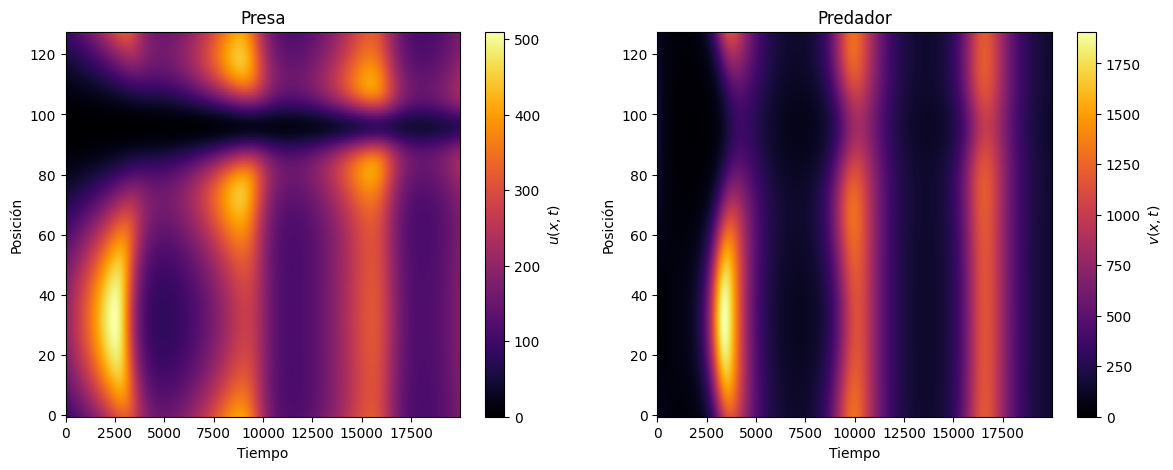

In [107]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

im1 = ax1.imshow(u1_u, origin='lower', aspect='auto', cmap='inferno')
ax1.set_xlabel('Tiempo')
ax1.set_ylabel('Posición')
ax1.set_title('Presa')
cbar1 = plt.colorbar(im1, ax=ax1, label='$u(x,t)$')

im2 = ax2.imshow(u1_v, origin='lower', aspect='auto', cmap='inferno')
ax2.set_xlabel('Tiempo')
ax2.set_ylabel('Posición')
ax2.set_title('Predador')
cbar2 = plt.colorbar(im2, ax=ax2, label='$v(x,t)$')

In [176]:
N = 128
x = np.linspace(0,2*np.pi,N,endpoint=False)

fig = plt.figure()

axis = plt.axes(title = 'Evolución a distintos tiempos', xlabel = '$x$', ylabel = '$u$',
                xlim =(min(x)-0.1, max(x)+0.1), ylim =(min(map(min, u1_v))-0.1, max(map(max, u1_v))+0.1))
line1, = axis.plot([], [], lw = 2, color = 'green', label = '$u(t)$')
line2, = axis.plot([], [], lw = 2, color = 'black', label = '$v(t)$')
plt.grid(True)
plt.legend(loc = 'upper right')

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return line1, line2,

def animate(i):
    x = np.linspace(0,2*np.pi,N,endpoint=False)
    y1 = u1_u[:, i*50]
    y2 = u1_v[:, i*50]
    line1.set_data(x, y1)
    line2.set_data(x, y2)
    return line1, line2,

anim = FuncAnimation(fig, animate, init_func = init, frames = 200, interval = 70, blit = True, repeat = True)

plt.close()

In [177]:
HTML(anim.to_html5_video())

Ahora, estudiamos una solución con parámetros $ a = 0.5 $, $ b = 0.1 $, $ c = 2 $, $d = 0.01$, junto a $D_1 = 0.001$ y $D_2 = 1 $. Las condiciones iniciales son las mismas que antes.

In [109]:
u2_u, u2_v = LotkaVolterra(0, 20, 1e-3, 128, 0.5, 0.1, 2, 0.01, 0.001, 1, lambda x: 100*np.sin(x) + 100, lambda x: -100*np.sin(x) + 100)

  0%|          | 0/19999 [00:00<?, ?it/s]

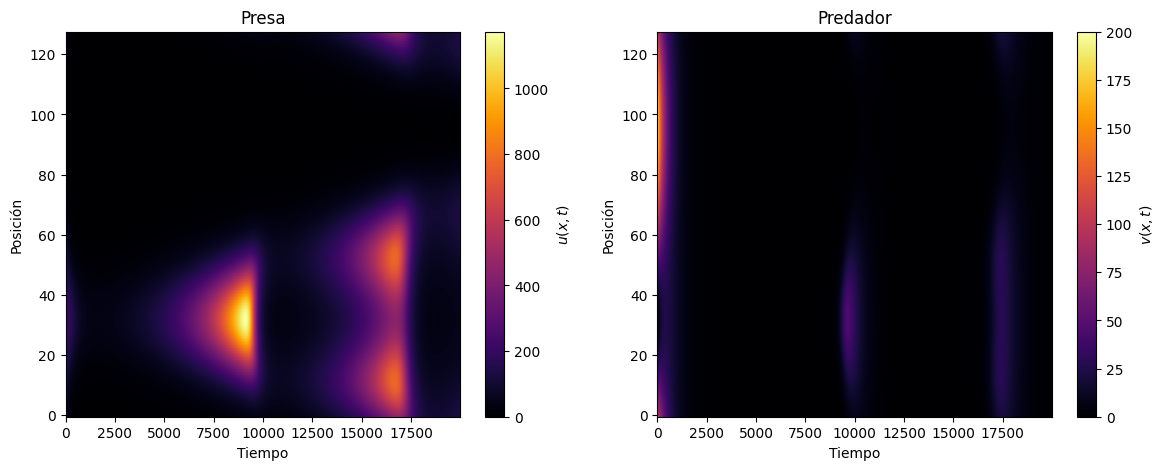

In [110]:
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(14, 5))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

im3 = ax3.imshow(u2_u, origin='lower', aspect='auto', cmap='inferno')
ax3.set_xlabel('Tiempo')
ax3.set_ylabel('Posición')
ax3.set_title('Presa')
cbar3 = plt.colorbar(im3, ax=ax3, label='$u(x,t)$')

im4 = ax4.imshow(u2_v, origin='lower', aspect='auto', cmap='inferno')
ax4.set_xlabel('Tiempo')
ax4.set_ylabel('Posición')
ax4.set_title('Predador')
cbar4 = plt.colorbar(im4, ax=ax4, label='$v(x,t)$')

Inmediatamente notamos que al haber aumentado el acoplamiento entre especies $b$, la tasa de aniquilación de las presas aumenta enormemente. Eso a su vez se traduce en la desaparición de predadores.

Ahora, estudiamos una solución con parámetros $ a = 0.1 $, $ b = 0.001 $, $ c = 10 $, $d = 0.1$, junto a $D_1 = 0.001$ y $D_2 = 1 $. Las condiciones iniciales son las mismas que antes.

In [129]:
u3_u, u3_v = LotkaVolterra(0, 20, 1e-3, 128, 0.1, 0.001, 10, 0.1, 0.001, 1, lambda x: 100*np.sin(x) + 100, lambda x: -100*np.sin(x) + 100)

  0%|          | 0/19999 [00:00<?, ?it/s]

In [130]:
fig, (ax4, ax5) = plt.subplots(1, 2, figsize=(14, 5))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

im4 = ax4.imshow(u3_u, origin='lower', aspect='auto', cmap='inferno')
ax4.set_xlabel('Tiempo')
ax4.set_ylabel('Posición')
ax4.set_title('Presa')
cbar4 = plt.colorbar(im4, ax=ax4, label='$u(x,t)$')

im5 = ax5.imshow(u3_v, origin='lower', aspect='auto', cmap='inferno')
ax5.set_xlabel('Tiempo')
ax5.set_ylabel('Posición')
ax5.set_title('Predador')
cbar5 = plt.colorbar(im5, ax=ax5, label='$v(x,t)$')

En este caso, hemos bajado la tasa de nacimientos de las presas $a$, aunque hemos aumentado enormemente la tasa de muertes de los predadores $c$, a la vez que aumentamos el acoplamiento entre especies $d$. Los resultados son los esperados: la población de presas se mantiene relativamente estable, con cambios periódicos debido a la proliferación de depredadores. Estos últimos, como puede apreciarse en el gráfico de la derecha, mueren rápidamente debido a su alta tasa de mortalidad.

En los tres casos, hemos notado que la dinámica de los sistemas tiende a adquirir un comportamiento periódico, lo cual se explica en parte por las condiciones iniciales que hemos escogido. Notamos, a su vez, que las presas son altamente sensibles a los parámetros de acoplamiento. La presencia de un número grande de presas tiende a proliferar rápidamente la aparición de predadores.

**Inciso b**

Estudiamos el primer caso de los 3 presentados anteriormente, pero variamos los parámetros $D_1$ y $D_2$.

In [164]:
u4_u, u4_v = LotkaVolterra(0, 20, 1e-3, 128, 0.5, 0.001, 2, 0.01, 0.1, 0.001, lambda x: 100*np.sin(x) + 100, lambda x: -100*np.sin(x) + 100)
u5_u, u5_v = LotkaVolterra(0, 20, 1e-3, 128, 0.5, 0.001, 2, 0.01, 0.1, 0.000001, lambda x: 100*np.sin(x) + 100, lambda x: -100*np.sin(x) + 100)

  0%|          | 0/19999 [00:00<?, ?it/s]

  0%|          | 0/19999 [00:00<?, ?it/s]

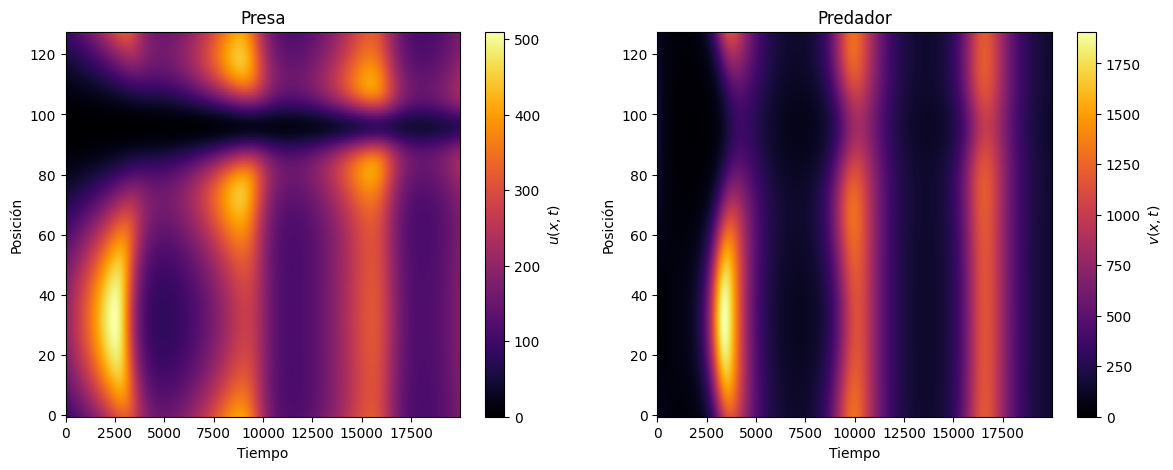

In [137]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

im1 = ax1.imshow(u1_u, origin='lower', aspect='auto', cmap='inferno')
ax1.set_xlabel('Tiempo')
ax1.set_ylabel('Posición')
ax1.set_title('Presa')
cbar1 = plt.colorbar(im1, ax=ax1, label='$u(x,t)$')

im2 = ax2.imshow(u1_v, origin='lower', aspect='auto', cmap='inferno')
ax2.set_xlabel('Tiempo')
ax2.set_ylabel('Posición')
ax2.set_title('Predador')
cbar2 = plt.colorbar(im2, ax=ax2, label='$v(x,t)$')

Aquí arriba hemos presentado el caso con $D_1 = 0.001$ y $D_2 = 1 $.

In [143]:
fig, (ax6, ax7) = plt.subplots(1, 2, figsize=(14, 5))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

im6 = ax6.imshow(u4_u, origin='lower', aspect='auto', cmap='inferno')
ax6.set_xlabel('Tiempo')
ax6.set_ylabel('Posición')
ax6.set_title('Presa')
cbar6 = plt.colorbar(im6, ax=ax6, label='$u(x,t)$')

im7 = ax7.imshow(u4_v, origin='lower', aspect='auto', cmap='inferno')
ax7.set_xlabel('Tiempo')
ax7.set_ylabel('Posición')
ax7.set_title('Predador')
cbar7 = plt.colorbar(im7, ax=ax7, label='$v(x,t)$')

Aquí arriba hemos presentado el caso con $D_1 = 0.1$ y $D_2 = 0.001 $.

In [165]:
fig, (ax8, ax9) = plt.subplots(1, 2, figsize=(14, 5))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

im8 = ax8.imshow(u5_u, origin='lower', aspect='auto', cmap='inferno')
ax8.set_xlabel('Tiempo')
ax8.set_ylabel('Posición')
ax8.set_title('Presa')
cbar8 = plt.colorbar(im8, ax=ax8, label='$u(x,t)$')

im9 = ax9.imshow(u5_v, origin='lower', aspect='auto', cmap='inferno')
ax9.set_xlabel('Tiempo')
ax9.set_ylabel('Posición')
ax9.set_title('Predador')
cbar9 = plt.colorbar(im9, ax=ax9, label='$v(x,t)$')

Aquí arriba hemos presentado el caso con $D_1 = 0.1$ y $D_2 = 1 \cdot 10^{-6}  $.

El efecto que estos coeficientes poseen se aprecia en la cantidad de presas/predadores que perduran a lo largo de tiempo: a medida que los coeficientes de difusión son menores, se observan regiones del espacio con nula cantidad de individuos. En particular, y en especial en el último caso, ocurre que la difusión de la presas es mucho mayor a la difusión de los predadores. A nivel cualitativo, podemos pensar que la presas tienen una mayor probabilidad de desplazarse a otras zonas del espacio con respecto a la de los predadores. Es por esto que se producen fenómenos como el del último caso, en el cual es posible apreciar como las poblaciones de predadores no son constantes en el espacio, sino que se ven *interrumpidas* por "franjas" de población nula. Cosa que no ocurre con las presas, cuyo patrón poblacional aparece más suave.

Como complemento de lo anterior, podemos apreciar que el primer gráfico posee índices de difusión relativamente mayores, por lo cual las poblaciones de presas y predadores tienden a llenar de forma mas uniforme el espacio, sin dejar regiones despobladas.

**Ejercicio 2**

$ \bf {a)} $ Se tiene la ecuación

$$ v_t + v_{xx} + v_{xxxx} + v v_x = 0 $$

Esta ecuación tiene invariancia de traslación (Galileo):

$$ x → x + \alpha $$
$$ u → u + \beta $$

e invariancia de reflexión:

$$ x → -x $$

Teniendo en cuenta las condiciones de contorno periódicas y las simetrías, elegimos una base de Fourier $ u(x, t) = \sum_k a_k(t) \varphi_k(x) $, con $ \varphi_k(x) = e^{i \frac{2k \pi x}{L}} $. Entonces, notemos que:

$ \cdot) \int_0^L e^{i \frac{2 (k-l) \pi x}{L}} dx = L\delta_{kx} $

$ \cdot) \partial_x \varphi_x = i \frac{2 \pi k}{L} \varphi_k $

$ \cdot) \partial_{xx} \varphi_k = - \left( \frac{2\pi k}{L} \right)^2 \varphi_k $

$ \cdot) \partial_{xxxx} \varphi_k = \left( \frac{2 \pi k}{L} \right)^4 \varphi_k $

Además, $ a_k(t) = a_k^*(t) $, pues los distintos $a_k$ son reales. Entonces, si reemplazamos todas estas derivadas en la ecuación de KS, multiplicamos por $\varphi_l^* = \varphi_{-l} $ e integramos espacialmente entre  $0$ y $L$, obtenemos la expresión:

$$ \int\limits_0^L \left[\sum_k \dot{a}_k \varphi_k - \left(\frac{2 \pi k}{L} \right)^2 a_k \varphi_k + \left(\frac{2 \pi k}{L}  \right)^4 a_k \varphi_k \right] \varphi_{-l} \, dx \, + $$

$$ + \int\limits_0^L \left(\sum_k i \frac{2 \pi k}{L} a_k \varphi_k \sum_j i  \frac{2\pi j}{L} a_j \varphi_j  \right) \varphi_{-j} \, dx = 0 $$

Si aplicamos propiedades de ortogonalidad, llegamos a

$$ \boxed{\left[\dot{a}_l - \left( \frac{2 \pi l}{L} \right)^2 + \left(\frac{2 \pi l}{L} \right)^4 a_l - \frac{1}{2} \left(\frac{2 \pi}{L} \right)^2 \sum_j j (l-j) a_j a_{l-j} \right] = 0} $$

$ \bf{b)} $ Si hacemos el cambio de variable $ t' = \left(\frac{2 \pi}{L} \right)^2 t $ y truncamos a 4 modos, obtenemos:

$ 1) \, \dot{a}_1 = \left[1 - \left(\frac{2 \pi}{L} \right)^2 \right]a_1 - 2a_1^* a_2 - 6a_2^* a_3 -12 a_3^* a_4 $

$ 2) \, \dot{a}_2 = 4 \left[1 - \left(\frac{4 \pi}{L} \right)^2 \right]a_2 + \frac{a_1^2}{2}  - 3a_1^* a_3 -8 a_2^* a_4 $

$ 3) \, \dot{a}_3 = 9 \left[1 - \left(\frac{6 \pi}{L} \right)^2 \right]a_3 + 2a_1 a_2 -4 a_1^* a_4 $

$ 4) \, \dot{a}_4 = 16 \left[1 - \left(\frac{8 \pi}{L} \right)^2 \right]a_4 + 2a_2^2 + 3 a_1 a_3 $

Estudiemos ahora la bifurcación a 2 modos. Entonces, notemos que $u = 0$ es un punto fijo, lo cual equivale a que $a_l = 0$, para todo $l$. Si linealizamos el sistema en el entorno del punto fijo, la truncación resulta:

$$ \dot{a}_l = l^2 \left[1 - \left(\frac{2 \pi l}{L} \right)^2 \right]a_l $$

donde despreciamos los términos a orden no lineal. Entonces, la estabilidad del sistema viene dada por el signo del término $ 1 - \left(\frac{2 \pi l}{L} \right)^2 $. Entonces, si $L > 2 \pi l$, entonces el modo es estable. Para truncar a 2 modos, establecemos el ancho del dominio en $L = 2\pi$ y, por lo tanto,

$ 1) \, \dot{a}_1 = \left[1 - \left(\frac{2 \pi}{L} \right)^2 \right]a_1 - 2a_1^* a_2 $

$ 2) \, \dot{a}_2 = 4 \left[1 - \left(\frac{4 \pi}{L} \right)^2 \right]a_2 + \frac{a_1^2}{2} $

Notamos que $ 1 - \left(\frac{2 \pi}{L} \right)^2 \equiv \lambda_1 > 0 $ y que $ 1 - \left(\frac{4 \pi}{L} \right)^2 \equiv \lambda_2 < 0 $, con lo cual, aparece la primera bifurcación.

Para caracterizar los puntos fijos, escribimos:

$ 1) \, \dot{a}_1 = \lambda_1 a_1 - 2a_1^* a_2 $

$ \, \dot{a}_1^* = \lambda_1 a_1^* - 2a_1 a_2^* $

$ 2) \, \dot{a}_2 = \lambda_2 a_2 + \frac{a_1^2}{2} $

$ \, \dot{a}_2^* = \lambda_2 a_2^* + \frac{{a_1^2}^*}{2} $

De $ \dot{a}_2 = 0 $, obtenemos que $a_2 = -\frac{a_1^2}{2 \lambda_2}$, mientras que $\dot{a}_1 = 0$, obtenemos que

$$ a_1 \left(\lambda_1 + \frac{|a_1|^2}{\lambda_2} \right) = 0$$

Con lo cual, aún siendo $u = 0$ (es decir, $a_1 = 0 = a_2$) un punto fijo, acaba de aparecer un nuevo punto fijo:

$$ |a_1| = \sqrt{\lambda_1 |\lambda_2|} $$

Esta es una bifurcación Pitchfork. En la medida que el ancho del espacio aumente en un factor entero de $2\pi$, se producirán nuevas bifurcaciones Pitchfork, ya que apareceran nuevos puntos fijos. A la larga, en las soluciones del sistema terminará predominando el caos espacio-temporal.

In [211]:
def evol2(u, k, L, N, dt):
    f  = np.fft.rfft(u)     #vaya al espacio de Fourier
    ft = f
    for ord in [2,1]:       # Bucle para el Runge-Kutta
        D   = dt/ord
        f_k = k*f
        fux = compute_advection(f_k)
        f_k_2 = k*f_k
        f_k_4 = (k**2)*f_k_2
        f = ft + D*(f_k_2 -(f_k_4/(L**2)) - 0.5*fux)              # escriba aquí su integrador temporal
        f[int(N/3):] = 0    # Dealiasing (eliminemos modos espúreos!)
    out = np.fft.irfft(f)  #Vuelva del espacio de Fourier
    return out

def compute_advection(f):
    fx = 1j*f
    out = np.fft.rfft(np.fft.irfft(fx)**2)
    return out

In [212]:
def KS(u0: np.array, k: np.array, L: float, N: int, dt: float, step: int):

    out = np.zeros((N,step))
    out[:,0] = u0
    for i in tqdm(np.arange(step-1)): # Evolución temporal
        if (type(L) == float) or (type(L) == int):
            out[:,i+1] = evol2(out[:,i],k,L,N,dt)
        else:
            out[:,i+1] = evol2(out[:,i],k,L[i],N,dt)

    return out

def eliminar_modo_cero(u:np.ndarray) -> np.ndarray:

    for i in range(u.shape[1]):
        u[:,i] = u[:,i]-np.mean(u[:,i])

    return u


In [213]:
#Defino mis puntos en el espacio real y los modos para el espacio de Fourier
x = np.linspace(0,2*np.pi,N,endpoint=False) # Coordenada espacial en [0,L)
t = np.arange(0,tf,dt)                      # Tiempo
k = np.arange(0,N/2+1)                      # Números de onda ordenados como en la FFT

# Perfil inicial
u0 = np.cos(x)+np.cos(2*x)+np.cos(3*x)/2

In [201]:
N = 128

dt = 10e-6
tf = 60000*dt
step = int(tf/dt)

# Parametro de la ecuacion diferencial
L = 8

In [202]:
u_KS1 = eliminar_modo_cero(KS(u0, k, L, N, dt, step))

  0%|          | 0/59999 [00:00<?, ?it/s]

In [204]:
N = 128

dt = 10e-6
tf = 60000*dt
step = int(tf/dt)

# Parametro de la ecuacion diferencial
L = 20

In [205]:
u_KS2 = eliminar_modo_cero(KS(u0, k, L, N, dt, step))

  0%|          | 0/59999 [00:00<?, ?it/s]

In [214]:
N = 512

dt = 10e-6
tf = 60000*dt
step = int(tf/dt)

# Parametro de la ecuacion diferencial
L = 80

In [215]:
u_KS3 = eliminar_modo_cero(KS(u0, k, L, N, dt, step))

  0%|          | 0/59999 [00:00<?, ?it/s]

In [216]:
fig, (ax10, ax11) = plt.subplots(1, 2, figsize=(14, 5))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

im10 = ax10.imshow(u_KS1, origin='lower', aspect='auto', cmap='hot')
ax10.set_xlabel('Tiempo')
ax10.set_ylabel('Posición')
ax10.set_title('Kuramoto - Sivashinsky $L = 8$')
cbar10 = plt.colorbar(im10, ax=ax10, label='$u(x,t)$')

im11 = ax11.imshow(u_KS2, origin='lower', aspect='auto', cmap='hot')
ax11.set_xlabel('Tiempo')
ax11.set_ylabel('Posición')
ax11.set_title('Kuramoto - Sivashinsky $L = 20$')
cbar11 = plt.colorbar(im11, ax=ax11, label='$u(x,t)$')

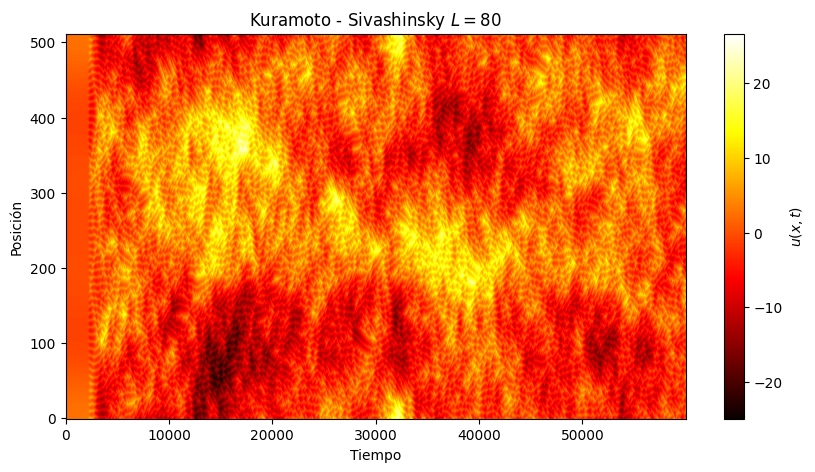

In [218]:
fig, ax12 = plt.subplots(figsize=(10, 5))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

im12 = ax12.imshow(u_KS3, origin='lower', aspect='auto', cmap='hot')
ax12.set_xlabel('Tiempo')
ax12.set_ylabel('Posición')
ax12.set_title('Kuramoto - Sivashinsky $L=80$')
cbar12 = plt.colorbar(im12, ax=ax12, label='$u(x,t)$')

Como podemos notar, en vista con lo hallado en el inciso anterior, aumentar el tamaño del dominio agrega bifurcaciones al sistema, comenzando por ondas viajeras para dominios pequeños y convirtiendose en caos espacio-temporal para dominios muy grandes. Por lo cual, en la medida que manejamos dominios espaciales muy grandes, no alcanza con pocos modos para describir la dinámica del sistema, pues las soluciones caóticas, que son las dominantes, no son captadas por una truncación a pocos modos.

A continuación, vamos a calcular la función de estructura y el espectro para este último caso de $L = 80$. Más abajo se encuentra la resolución concreto de los últimos dos incisos.

In [233]:
# def evol_kuramoto_sivashinsky, compute_advection & kuramoto_sivashinsky_pseudoespectral
def evol_kuramoto_sivashinsky(
    u: ArrayLike,
    k: ArrayLike,
    L: float,
    dt: float,
):
    """Evoluciona en el tiempo la PDE usando el método pseudoespectral y \
Runge-Kutta de segundo orden.
    """
    u_hat = np.fft.rfft(u)  # Transformamos al espacio de Fourier
    u_hat_inicial = u_hat  # Guardamos el estado inicial
    for ord in [2, 1]:  # Bucle para el Runge-Kutta
        D = dt / ord
        u_x_2_hat = compute_advection(u_hat, k)
        u_hat = u_hat_inicial + D * (
            + (k**2)*u_hat - (k**4)*(u_hat/(L**2)) - u_x_2_hat/2
        )  # Integramos en el tiempo
        u_hat[(u.size // 3) :] = 0  # Dealiasing (eliminemos modos espúreos!)
    u_nuevo = np.fft.irfft(u_hat)  # Vuelva del espacio de Fourier
    return u_nuevo


def compute_advection(u_hat, k):
    """Calcula u_x^2 usando el método pseudoespectral y devuelve el resultado \
en el espacio Fourier.
    """
    u_x = np.fft.irfft(1j*k*u_hat)
    u_x_2_hat = np.fft.rfft(u_x**2)
    return u_x_2_hat


def kuramoto_sivashinsky_pseudoespectral(
    u0: Callable[[ArrayLike], ArrayLike],
    L: float,
    tf: float = 5,
    dt: float = 5e-5,
    nx: int = 128,
) -> tuple[ArrayLike, ArrayLike, ArrayLike]:
    # Defino mis puntos en el espacio real y los modos para el espacio de Fourier
    x_vals = np.linspace(0, 2*np.pi, nx, endpoint=False)  # Coordenada espacial en [0,2*pi)
    t_vals = np.arange(0, tf + dt/2, dt)  # Tiempo
    nt = t_vals.size
    # Números de onda ordenados como en la FFT
    k_vals = np.fft.rfftfreq(nx, d=(x_vals[1] - x_vals[0])) * 2 * np.pi

    # Inicializamos el array con la solución
    u = np.empty([nx, nt])  # Array con la velocidad
    u[:, 0] = u0(x_vals)  #￼ Condiciones iniciales

    # Aplico el método de Euler para la integración temporal
    for n in tqdm(range(nt - 1)):
        u[:, n+1] = evol_kuramoto_sivashinsky(u[:, n], k_vals, L, dt=dt)
    return x_vals, t_vals, u

In [234]:
dt = 1e-6
tf = 160_000*dt
L = 80
x_vals, t_vals, u = kuramoto_sivashinsky_pseudoespectral(
#    lambda x: gaussian(x, np.pi, np.pi/3),
    lambda x: np.cos(x)+np.cos(2*x)+np.cos(3*x)/2,
    L=L,
    tf=tf,
    nx=512,
    dt=dt,
)
u_plot = u - np.mean(u, axis=0, keepdims=True)

  0%|          | 0/160000 [00:00<?, ?it/s]

In [225]:
@njit
def media_compatible_con_numba(a, axis):
    return np.sum(a, axis=axis) / a.shape[axis]

@njit(parallel=True)
def diferencia_cuadratica_shifteada(u, l_vals):
    s_2 = np.zeros_like(u)
    for i in prange(1, l_vals.size):  # start from 1
        delta_u_l = np.concatenate((u[-i:, :], u[:-i, :]), axis=0) - u
        s_2[i] = media_compatible_con_numba(delta_u_l**2, axis=0)
    return media_compatible_con_numba(s_2, axis=1)

def calcular_estructura_numba(
    u: ArrayLike, x_vals: ArrayLike, sample_size: int, seed: int = 42,
) -> ArrayLike:

    l_vals = np.linspace(0, np.max(x_vals) - np.min(x_vals), x_vals.size)
    s_2 = np.zeros_like(x_vals)
    rng = np.random.default_rng(seed)
    u_muestra = rng.choice(u, size=sample_size, replace=False, axis=1)
    s_2 = diferencia_cuadratica_shifteada(u_muestra, l_vals)
    return s_2, l_vals

In [226]:
t_min_dinamica = 0.02
filtro_t = t_vals > t_min_dinamica
u_dinamica = u[:, filtro_t]

estructura, l_vals = calcular_estructura_numba(u_dinamica, x_vals, sample_size=10_000)

k_vals = np.fft.rfftfreq(x_vals.size, d=(x_vals[1] - x_vals[0])) * 2 * np.pi
u_hat = np.fft.rfft(u_dinamica, axis=0)
espectro_potencia = np.mean(np.abs(u_hat)**2, axis=1)[:2*(k_vals.size // 3)]
k_vals = k_vals[:2*(k_vals.size // 3)]


**Inciso d**

Al final de los gráficos, se presenta el análisis de los resultados.

In [237]:
idx_min = 2
idx_max = 35
k_fit = k_vals[idx_min:idx_max]
e_fit = espectro_potencia[idx_min:idx_max]
popt, pcov = np.polyfit(np.log(k_fit), np.log(e_fit), 1, cov=True, )
perr = np.sqrt(np.diag(pcov))
alpha_val = popt[0]
alpha_err = perr[0]
plt.title('Espectro')
plt.plot(k_vals, espectro_potencia, "-", mec="k", mew=0.5)
plt.plot(k_fit, np.exp(popt[1])*k_fit**popt[0], "--")
plt.axvline(k_vals[idx_min], color="k", linestyle="--")
plt.axvline(k_vals[idx_max], color="k", linestyle="--")
plt.grid()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$k$")
plt.ylabel("$E(k)$")
plt.show()

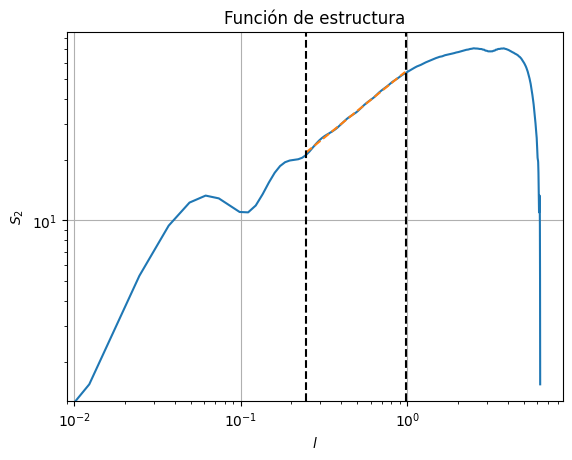

In [238]:
idx_min = 20
idx_max = 80
l_fit = l_vals[idx_min:idx_max]
s_fit = estructura[idx_min:idx_max]
popt, pcov = np.polyfit(np.log(l_fit), np.log(s_fit), 1, cov=True, )
perr = np.sqrt(np.diag(pcov))
beta_val = popt[0]
beta_err = perr[0]
plt.title('Función de estructura')
plt.plot(l_vals, estructura, "-", mec="k", mew=0.5)
plt.plot(l_fit, np.exp(popt[1])*l_fit**popt[0], "--")
plt.axvline(l_vals[idx_min], color="k", linestyle="--")
plt.axvline(l_vals[idx_max], color="k", linestyle="--")
plt.grid()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$l$")
plt.ylabel("$S_2$")
plt.show()

Notar que el dominio $l$ de este último gráfico se víncula con $k$ a partir de la expresión $k \approx l^{-1}$.

Donde se han ajustado leyes de escala del orden de $E \approx k^\alpha $ y $S \approx l^\beta $, en las regiones marcadas en color naranja y delimitadas por las rectas negras. Este es el rango de autosimilaridad que hemos elegido para encontrar las leyes de potencias. Gracias a estas sabemos que $\alpha$ está relacionada con $n \in (1, 3)$ de manera tal que $-\alpha = n$, mientras que el exponente $\beta$ se relaciona con $n$ mediante la expresión $\beta = n -1 $.

**Inciso e**

A partir de los valores de $\alpha$ y $\beta$ hallados con los ajustes de ítem anterior, obtenemos los siguiente valores de $n$:

In [240]:
print(f"n_α = {-alpha_val:.2f}")
print(f"n_β = {beta_val + 1:.3f}")

n_α = 1.81
n_β = 1.669


Es decir, $n_\alpha = 1.81$ y $n_\beta = 1.67$. Si bien deberían ser iguales, difieren en aproximadamente $0.14$, aunque cumplen la condición de pertenecer al intervalo $(1,3)$. Cabe mencionar que los valores de $\alpha$ y $\beta$ hallados dependen fuertemente del rango lineal (disipativo) que se tome en las gráficas del espectro y de la función de estructura.